# Power Analysis for Adjusters

Unadjusted vs. adjusted conformal test martingale under a changepoint alternative

Two notions of statistical power are considered:
1. **Power of a test**: $$Q(\phi_t = 1),$$ where $\phi_t = 1(\mathfrak{e}_t \geq 1/\alpha)$.
2. **E-Power**: $$\mathbb{E}_Q[\log \mathfrak{e}_t].$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import os

import ecombine as ec

In [2]:
# basic figure styles
ec.set_theme()

# rng for (randomized) inference methods
rng = np.random.default_rng(30105202)
# rng seed for data generator
rng_data_seed = 20250103

# Adjuster type (important for power!)
# adjuster_type, adjuster_kwargs = "default", dict(use_maximum=True, use_zero=False, kappa=None)  # default: mixture of (no zero) adjusters
adjuster_type, adjuster_kwargs = "zero", dict(use_maximum=True, use_zero=True, kappa=1.0)  # zero adjuster
# adjuster_type, adjuster_kwargs = "kappa25", dict(use_maximum=True, use_zero=False, kappa=.25)  # no zero adjuster, growth rate 3/4 of max

# plots saved here
plots_dir = "./plots/exch/power_analysis_conformal_only" + ("" if adjuster_type == "default" else f"_{adjuster_type}")
plot_fmt = "pdf"
os.makedirs(plots_dir, exist_ok=True)
mpl.rc("savefig", format=plot_fmt, dpi=350)

### Setup: Adjusted Conformal Test Martingale against a Changepoint Alternative

In [3]:
# number of repeated trials
N_TRIALS = 100

# max sequence length
T = 2000

# significance level
ALPHA = 0.1

# change sizes (q = p + change_size)
BASE_P = 0.3
CHANGE_SIZES = (0.0, 0.1, 0.2, 0.3, 0.4)

# data rng
rng_data = np.random.default_rng(rng_data_seed)

In [4]:
# conformal hyperparams
jump = 0.01
jumper_weights = (1/3, 1/3, 1/3)
# jumper_weights = (0.5, 0.0, 0.5)

### Changepoint Alternative (one "shock")

Conformal test martingales grow quickly against changepoint alternatives.

The following data repeatedly changes from $Ber(p)$ to $Ber(q)$ and vice versa every `change_every` steps.

In [5]:
p, q = BASE_P, BASE_P + CHANGE_SIZES[-1]
change_every = 100
x_change_rep = ec.data.exch.generate_binary_change_repeated(
    p=p, q=q, size=T, change_every=change_every, rng=rng_data
)
x_change_rep

array([0, 1, 0, ..., 1, 1, 0])

In [6]:
# for one-change config
p, q = 0.5, 0.2
change_loc = 0.2
change_len = 0.04

# # p, q = 0.5, 0.2
# # change_loc = 0.15
# # change_len = 0.05

# x_change1 = ec.data.exch.generate_binary_changepoint(
#     p=p, q=q, size=T, change_loc=change_loc, change_len=change_len,
#     rng=rng_data)
# x_change1[:10]

### Power of the induced test and E-Power

In [7]:
def run_power_experiment_changepoint(
        n_trials,
        change_sizes=CHANGE_SIZES,
        alpha=ALPHA,  # significance level
        data_config="repeated",  # "once", "twice"
        **conformal_kwargs
):
    """Run power experiment over repeated simulations."""

    full_df = []  # one df per run, combine at the end
    for change_size in change_sizes:
        p = BASE_P
        q = p + change_size
        # p = 0.5 - change_size / 2
        # q = 0.5 + change_size / 2
        for i in range(n_trials):
            # Generate data
            if data_config == "repeated":
                data = ec.data.exch.generate_binary_change_repeated(
                    p=p, q=q, size=T, change_every=change_every, rng=rng_data
                )
            elif data_config == "twice":
                data = ec.data.exch.generate_binary_change_twice(
                    p=p, q=q, size=T, rng=rng_data
                )
            else:
                data = ec.data.exch.generate_binary_changepoint(
                    p=p, q=q, size=T, change_loc=change_loc, change_len=change_len,
                    rng=rng_data,
                )
            # Compute unadjusted e-process
            eprocess = ec.eprocess_exch_conformal(data, **conformal_kwargs)

            # Adjust
            adj_eprocess = ec.adjuster(eprocess, **adjuster_kwargs)

            # # Compute the rejection of a test at level alpha
            # power = np.maximum.accumulate(eprocess) >= (1 / alpha)

            # # Compute e-power
            # epower = np.log(eprocess)

            # Add as df
            full_df.append(pd.DataFrame({
                "ChangeSize": change_size,
                "RunID": i, 
                "Time": np.arange(1, T + 1),
                "Data": data,
                "Unadjusted": eprocess,
                "Adjusted": adj_eprocess,
                "UnadjustedPower": np.maximum.accumulate(eprocess) >= (1 / alpha),
                "AdjustedPower": np.maximum.accumulate(adj_eprocess) >= (1 / alpha),
                "UnadjustedEPower": np.log(np.maximum(ec.EPS, eprocess)),
                "AdjustedEPower": np.log(np.maximum(ec.EPS, adj_eprocess)),
            }))
        # Aggregate all experiment results
    full_df = pd.concat(full_df, axis=0)
    return full_df

In [8]:
conformal_kwargs = dict(
    jump=jump,
    jumper_weights=jumper_weights,
    rng=rng,
)

full_df = run_power_experiment_changepoint(
    n_trials=N_TRIALS,
    change_sizes=CHANGE_SIZES,
    alpha=ALPHA,
    data_config="repeated",
    **conformal_kwargs
)
full_df

,ChangeSize,RunID,Time,Data,Unadjusted,Adjusted,UnadjustedPower,AdjustedPower,UnadjustedEPower,AdjustedEPower
0,0.0,0,1,0,1.000000e+00,0.000000e+00,False,False,0.000000e+00,-230.258509
1,0.0,0,2,1,1.000000e+00,0.000000e+00,False,False,-1.110223e-16,-230.258509
2,0.0,0,3,0,9.912112e-01,0.000000e+00,False,False,-8.827653e-03,-230.258509
3,0.0,0,4,0,1.006768e+00,0.000000e+00,False,False,6.745518e-03,-230.258509
4,0.0,0,5,1,1.054394e+00,0.000000e+00,False,False,5.296577e-02,-230.258509
...,...,...,...,...,...,...,...,...,...,...
1995,0.4,99,1996,1,1.175275e+30,4.903060e+26,True,True,6.923905e+01,61.457072
1996,0.4,99,1997,0,8.165807e+29,4.903060e+26,True,True,6.887492e+01,61.457072
1997,0.4,99,1998,1,9.807996e+29,4.903060e+26,True,True,6.905817e+01,61.457072
1998,0.4,99,1999,0,9.713227e+29,4.903060e+26,True,True,6.904846e+01,61.457072


In [9]:
single_df = full_df.loc[full_df["ChangeSize"] == CHANGE_SIZES[2]]
single_df

,ChangeSize,RunID,Time,Data,Unadjusted,Adjusted,UnadjustedPower,AdjustedPower,UnadjustedEPower,AdjustedEPower
0,0.2,0,1,0,1.000000,0.00000,False,False,0.000000e+00,-230.258509
1,0.2,0,2,1,1.000000,0.00000,False,False,-1.110223e-16,-230.258509
2,0.2,0,3,0,0.916471,0.00000,False,False,-8.722450e-02,-230.258509
3,0.2,0,4,0,0.973250,0.00000,False,False,-2.711405e-02,-230.258509
4,0.2,0,5,0,1.113371,0.00000,False,False,1.073926e-01,-230.258509
...,...,...,...,...,...,...,...,...,...,...
1995,0.2,99,1996,1,72.669966,71.89685,True,True,4.285928e+00,4.275232
1996,0.2,99,1997,1,86.516294,71.89685,True,True,4.460333e+00,4.275232
1997,0.2,99,1998,1,114.208603,71.89685,True,True,4.738027e+00,4.275232
1998,0.2,99,1999,1,145.980369,71.89685,True,True,4.983472e+00,4.275232


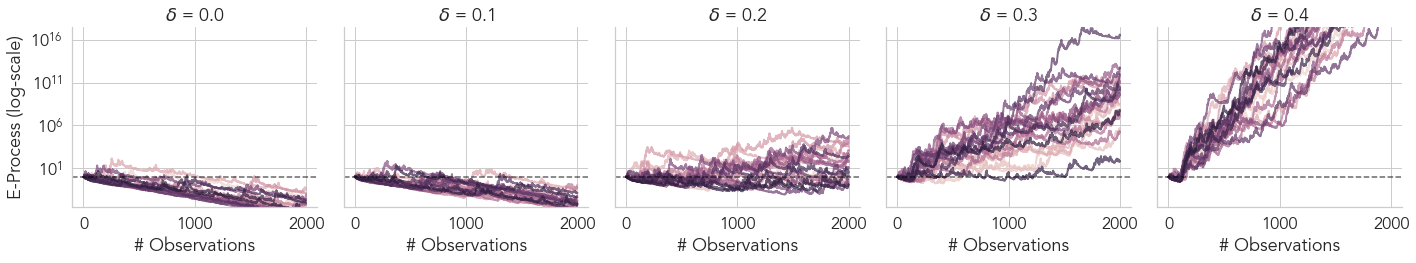

In [10]:
# Plot the first K e-processes
fg = sns.relplot(
    x="Time",
    y="Unadjusted",
    col="ChangeSize",
    kind="line",
    hue="RunID",
    aspect=1,
    height=4,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=full_df.loc[full_df["RunID"] <= 20],
    legend=None,
)
fg.set_titles(r"$\delta$" + " = {col_name}")
for ax in fg.axes.flatten():
    ax.set(
        xlabel="# Observations",
        ylabel="E-Process (log-scale)",
        yscale="log",
        ylim=(10 ** -3.5, 10 ** 17.5)
    )
    ax.axhline(y=1, color="black", alpha=0.6, linestyle="dashed")
fg.tight_layout()
fg.savefig(os.path.join(plots_dir, "EProcessesSample.pdf"), bbox_inches="tight")
fg.savefig(os.path.join(plots_dir, "EProcessesSample.png"), dpi=350, bbox_inches="tight")
None

### vs. # Observations

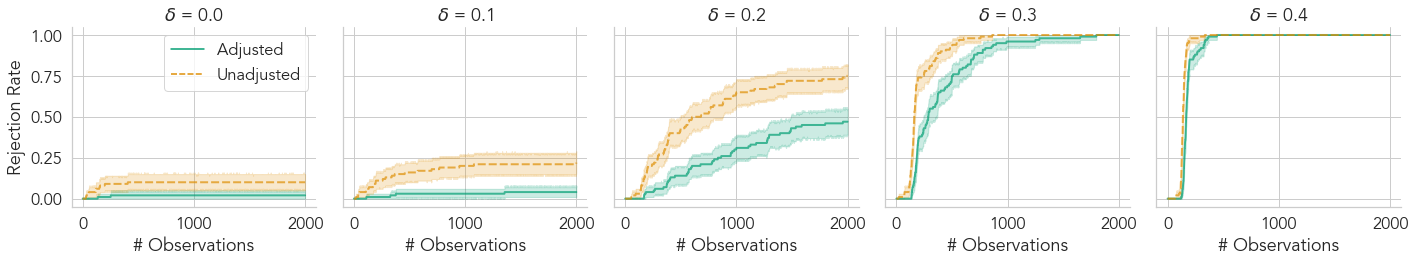

In [11]:
# Power
power_df = full_df.melt(
    id_vars=["RunID", "Time", "ChangeSize"], value_vars=["UnadjustedPower", "AdjustedPower"],
    var_name="E-Process", value_name="Power")
power_df["E-Process"] = power_df["E-Process"].map(
    {"UnadjustedPower": "Unadjusted", "AdjustedPower": "Adjusted"})
fg = sns.relplot(
    x="Time",
    y="Power",
    col="ChangeSize",
    hue="E-Process",
    hue_order=["Adjusted", "Unadjusted"],
    palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
    style="E-Process",
    style_order=["Adjusted", "Unadjusted"],
    kind="line",
    # markers=True,
    errorbar=("ci", 100 * (1 - ALPHA)),
    aspect=1,
    height=4,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=power_df,
    facet_kws=dict(legend_out=False),
)
fg._legend.set_title(None)
fg.set_titles(r"$\delta$" + " = {col_name}")
for ax in fg.axes.flatten():
    ax.set(
        ylim=(-0.05, 1.05),
        ylabel="Rejection Rate",
        xlabel="# Observations",
    )
fg.tight_layout()
fg.savefig(os.path.join(plots_dir, "PowerVsSampleSize.pdf"), bbox_inches="tight")
fg.savefig(os.path.join(plots_dir, "PowerVsSampleSize.png"), dpi=350, bbox_inches="tight")
None

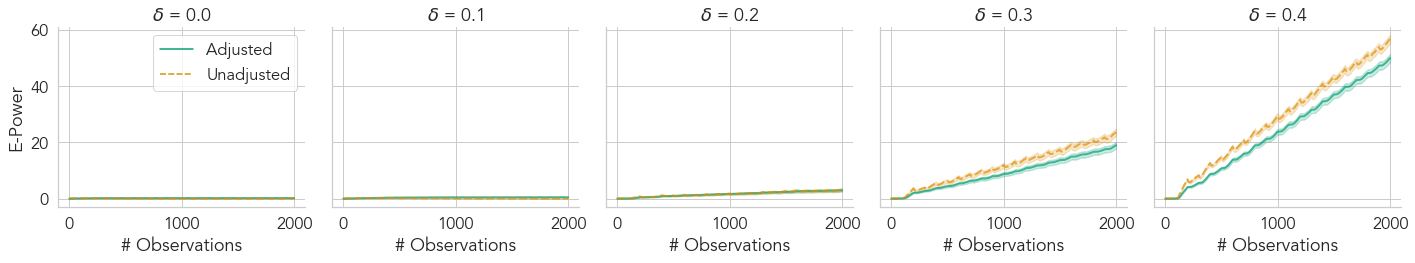

In [12]:
# E-Power
epower_df = full_df.melt(
    id_vars=["RunID", "Time", "ChangeSize"], value_vars=["UnadjustedEPower", "AdjustedEPower"],
    var_name="E-Process", value_name="E-Power")
epower_df["E-Process"] = epower_df["E-Process"].map(
    {"UnadjustedEPower": "Unadjusted", "AdjustedEPower": "Adjusted"})
# clip e-power at zero
epower_df["E-Power"] = np.maximum(0, epower_df["E-Power"])
fg = sns.relplot(
    x="Time",
    y="E-Power",
    col="ChangeSize",
    hue="E-Process",
    hue_order=["Adjusted", "Unadjusted"],
    palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
    style="E-Process",
    style_order=["Adjusted", "Unadjusted"],
    kind="line",
    # markers=True,
    errorbar=("ci", 100 * (1 - ALPHA)),
    aspect=1,
    height=4,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=epower_df,
    facet_kws=dict(legend_out=False),
)
fg._legend.set_title(None)
fg.set_titles(r"$\delta$" + " = {col_name}")
for ax in fg.axes.flatten():
    ax.set(
        ylabel="E-Power",
        xlabel="# Observations",
    )
fg.tight_layout()
fg.savefig(os.path.join(plots_dir, "EPowerVsSampleSize.pdf"), bbox_inches="tight")
fg.savefig(os.path.join(plots_dir, "EPowerVsSampleSize.png"), dpi=350, bbox_inches="tight")
None

### vs. Change Size

We "collapse" the sample size dimension by looking at whether a test was rejected within the 1000 steps.


In [13]:
idf = full_df.query(f"ChangeSize == {CHANGE_SIZES[2]} and RunID == 0")
idf

,ChangeSize,RunID,Time,Data,Unadjusted,Adjusted,UnadjustedPower,AdjustedPower,UnadjustedEPower,AdjustedEPower
0,0.2,0,1,0,1.000000,0.000000,False,False,0.000000e+00,-230.258509
1,0.2,0,2,1,1.000000,0.000000,False,False,-1.110223e-16,-230.258509
2,0.2,0,3,0,0.916471,0.000000,False,False,-8.722450e-02,-230.258509
3,0.2,0,4,0,0.973250,0.000000,False,False,-2.711405e-02,-230.258509
4,0.2,0,5,0,1.113371,0.000000,False,False,1.073926e-01,-230.258509
...,...,...,...,...,...,...,...,...,...,...
1995,0.2,0,1996,1,0.302252,10.014978,True,True,-1.196494e+00,2.304082
1996,0.2,0,1997,1,0.316204,10.014978,True,True,-1.151369e+00,2.304082
1997,0.2,0,1998,1,0.348988,10.014978,True,True,-1.052717e+00,2.304082
1998,0.2,0,1999,1,0.398363,10.014978,True,True,-9.203913e-01,2.304082


In [14]:
# Compute rejection times and max e-values
collapsed_df = []
for change_size in full_df.ChangeSize.unique():
    for run_id in full_df.RunID.unique():
        idf = full_df.query(f"ChangeSize == {change_size} and RunID == {run_id}")
        # print(change_size, run_id, idf.shape)
        unadj_reject_any = idf["UnadjustedPower"].any()
        unadj_reject_time = (idf["UnadjustedPower"].argmax() if unadj_reject_any else T) + 1
        unadj_e = idf["Unadjusted"].max()
        adj_reject_any = idf["AdjustedPower"].any()
        adj_reject_time = (idf["AdjustedPower"].argmax() if adj_reject_any else T) + 1
        adj_e = idf["Adjusted"].max()
        collapsed_df.append({
            "ChangeSize": change_size,
            "RunID": run_id,
            "Unadjusted": unadj_e,
            "UnadjustedPower": unadj_e >= (1 / ALPHA),
            "UnadjustedRejectionTime": unadj_reject_time,
            "Adjusted": adj_e,
            "AdjustedPower": adj_e >= (1 / ALPHA),
            "AdjustedRejectionTime": adj_reject_time,
        })
collapsed_df = pd.DataFrame(collapsed_df)
collapsed_df

,ChangeSize,RunID,Unadjusted,UnadjustedPower,UnadjustedRejectionTime,Adjusted,AdjustedPower,AdjustedRejectionTime
0,0.0,0,7.887952e+00,False,2001,3.698389e+00,False,2001
1,0.0,1,1.113747e+00,False,2001,0.000000e+00,False,2001
2,0.0,2,2.997399e+00,False,2001,0.000000e+00,False,2001
3,0.0,3,2.024359e+00,False,2001,0.000000e+00,False,2001
4,0.0,4,1.404399e+02,True,200,1.148753e+01,True,253
...,...,...,...,...,...,...,...,...
495,0.4,95,1.620377e+25,True,155,9.617942e+21,True,172
496,0.4,96,5.046879e+24,True,148,3.119761e+21,True,194
497,0.4,97,7.039779e+19,True,126,6.741296e+16,True,143
498,0.4,98,2.032240e+22,True,139,1.540470e+19,True,164


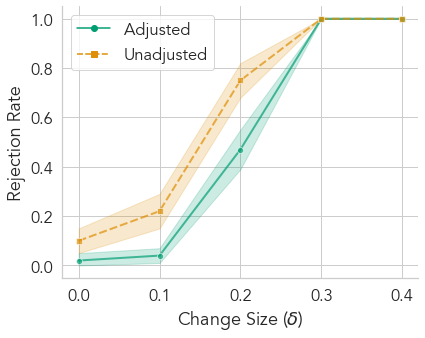

In [15]:
# Power vs. ChangeSize
power_change_df = collapsed_df.melt(
    id_vars=["ChangeSize", "RunID"],
    value_vars=["UnadjustedPower", "AdjustedPower"],
    var_name="E-Process", value_name="Power"
)
power_change_df["E-Process"] = power_change_df["E-Process"].map(
    {"UnadjustedPower": "Unadjusted", "AdjustedPower": "Adjusted"})
fg = sns.relplot(
    x="ChangeSize",
    y="Power",
    hue="E-Process",
    hue_order=["Adjusted", "Unadjusted"],
    palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
    style="E-Process",
    style_order=["Adjusted", "Unadjusted"],
    kind="line",
    markers=["o", "s"],
    errorbar=("ci", 100 * (1 - ALPHA)),
    aspect=1.25,
    height=5,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=power_change_df,
    facet_kws=dict(legend_out=False),
)
# remove legend title and rename items to 'Unadjusted' and 'Adjusted'
fg._legend.set_title(None)
fg.ax.set(
    # ylim=(-0.05, 1.05),
    ylabel="Rejection Rate",
    xlabel=r"Change Size ($\delta$)",
)
fg.tight_layout()
fg.savefig(os.path.join(plots_dir, "PowerVsChangeSize.pdf"), bbox_inches="tight")
fg.savefig(os.path.join(plots_dir, "PowerVsChangeSize.png"), dpi=350, bbox_inches="tight")
None

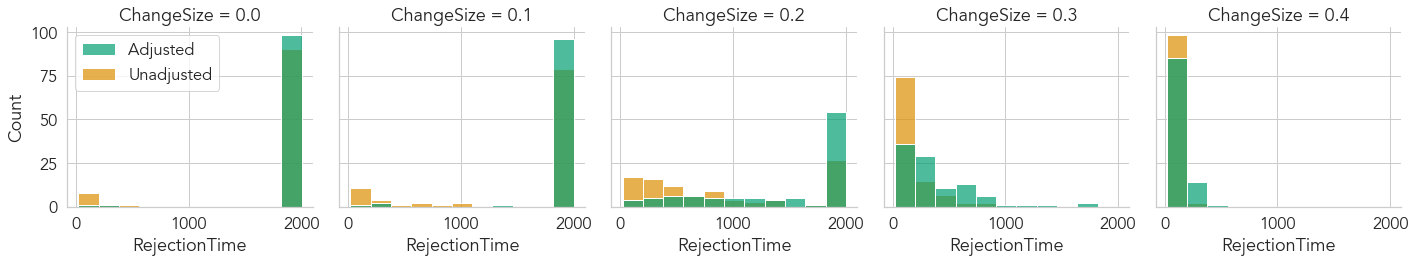

In [16]:
# Rejection Times Histogram
rejection_time_df = collapsed_df.melt(
    id_vars=["ChangeSize", "RunID"],
    value_vars=["UnadjustedRejectionTime", "AdjustedRejectionTime"],
    var_name="E-Process", value_name="RejectionTime"
)
rejection_time_df["E-Process"] = rejection_time_df["E-Process"].map(
    {"UnadjustedRejectionTime": "Unadjusted", "AdjustedRejectionTime": "Adjusted"})
# Rejection Times vs. ChangeSize
fg = sns.displot(
    x="RejectionTime",
    col="ChangeSize",
    hue="E-Process",
    hue_order=["Adjusted", "Unadjusted"],
    palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
    kind="hist",
    aspect=1,
    height=4,
    # linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=rejection_time_df,
    facet_kws=dict(legend_out=False),
)
# remove legend title
fg._legend.set_title(None)
fg.tight_layout()
fg.savefig(os.path.join(plots_dir, "RejectionTimeHistogram.pdf"), bbox_inches="tight")
fg.savefig(os.path.join(plots_dir, "RejectionTimeHistogram.png"), dpi=350, bbox_inches="tight")
None

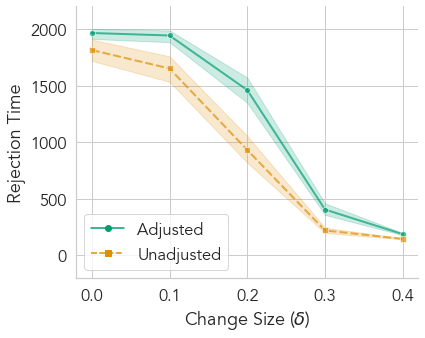

In [17]:
# Rejection Times vs. ChangeSize
fg = sns.relplot(
    x="ChangeSize",
    y="RejectionTime",
    hue="E-Process",
    hue_order=["Adjusted", "Unadjusted"],
    palette=[ec.PLOT_DEFAULT_COLORS[2], ec.PLOT_DEFAULT_COLORS[1]],  # green, orange
    style="E-Process",
    style_order=["Adjusted", "Unadjusted"],
    kind="line",
    markers=["o", "s"],
    errorbar=("ci", 100 * (1 - ALPHA)),
    aspect=1.25,
    height=5,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=rejection_time_df,
    facet_kws=dict(legend_out=False),
)
fg._legend.set_title(None)
# bottom left corner
fg.ax.legend(loc="lower left")
fg.ax.set(
    ylim=(-200, T+200),
    ylabel="Rejection Time",
    xlabel=r"Change Size ($\delta$)",
)
fg.tight_layout()
fg.savefig(os.path.join(plots_dir, "RejectionTimeVsChangeSize.pdf"), bbox_inches="tight")
fg.savefig(os.path.join(plots_dir, "RejectionTimeVsChangeSize.png"), dpi=350, bbox_inches="tight")
None

In [18]:
cdf = full_df.groupby(
    by=["ChangeSize", "RunID"],
).agg({"UnadjustedPower": "max", "AdjustedPower": "max"})
cdf

UnadjustedPower  AdjustedPower
ChangeSize RunID                                
0.0        0                False          False
           1                False          False
           2                False          False
           3                False          False
           4                 True           True
...                           ...            ...
0.4        95                True           True
           96                True           True
           97                True           True
           98                True           True
           99                True           True

[500 rows x 2 columns]

In [19]:
cdf.groupby(by="ChangeSize").agg(["mean", "sem"])

UnadjustedPower           AdjustedPower          
                      mean       sem          mean       sem
ChangeSize                                                  
0.0                   0.10  0.030151          0.02  0.014071
0.1                   0.22  0.041633          0.04  0.019695
0.2                   0.75  0.043519          0.47  0.050161
0.3                   1.00  0.000000          1.00  0.000000
0.4                   1.00  0.000000          1.00  0.000000